# Introduction to transcripton and Sound Source Separation  
### George Tzanetakis, University of Victoria

In this notebook, we will look at simple example of what is music transcription and sound source separation. 
We will be using the excellent Nussl Python framework for sound source separation. Music signals are complex mixtures of multiple individual sound sources organized hierarchically in time and frequency. The goal of automatic music trancsription is to recover a symbolic representation of the underlying music such as MIDI or MusicXML from the audio signal. Sound source separation refers to the process of extracting the audio signals of the individual sound sources that comprise the mixture. Let's look at these two tasks through examining a simple example case. 

In [1]:
import nussl
import matplotlib.pyplot as plt
import numpy as np
import copy

import time
start_time = time.time()

musdb = nussl.datasets.MUSDB18(download=False)



In [2]:
item = musdb[55]
mix = item['mix']
sources = item['sources']
mix.embed_audio()
print(mix)

AudioSignal (unlabeled): 6.803 sec @ Music Delta - Beatles, 44100 Hz, 2 ch.


In [3]:
sources['bass'].embed_audio()
print(sources['bass'])

AudioSignal (unlabeled): 6.803 sec @ musdb/Music Delta - Beatles_bass.wav, 44100 Hz, 2 ch.


In [4]:
sources['vocals'].embed_audio()
print(sources['vocals'])

AudioSignal (unlabeled): 6.803 sec @ musdb/Music Delta - Beatles_vocals.wav, 44100 Hz, 2 ch.


In [5]:
import crepe
time, vocals_frequency, confidence, activation = crepe.predict(sources['vocals'].audio_data.T, 44100, viterbi=True)
time, bass_frequency, confidence, activation = crepe.predict(sources['bass'].audio_data.T, 44100, viterbi=True)

22/22 [==============================] - 12s 555ms/step


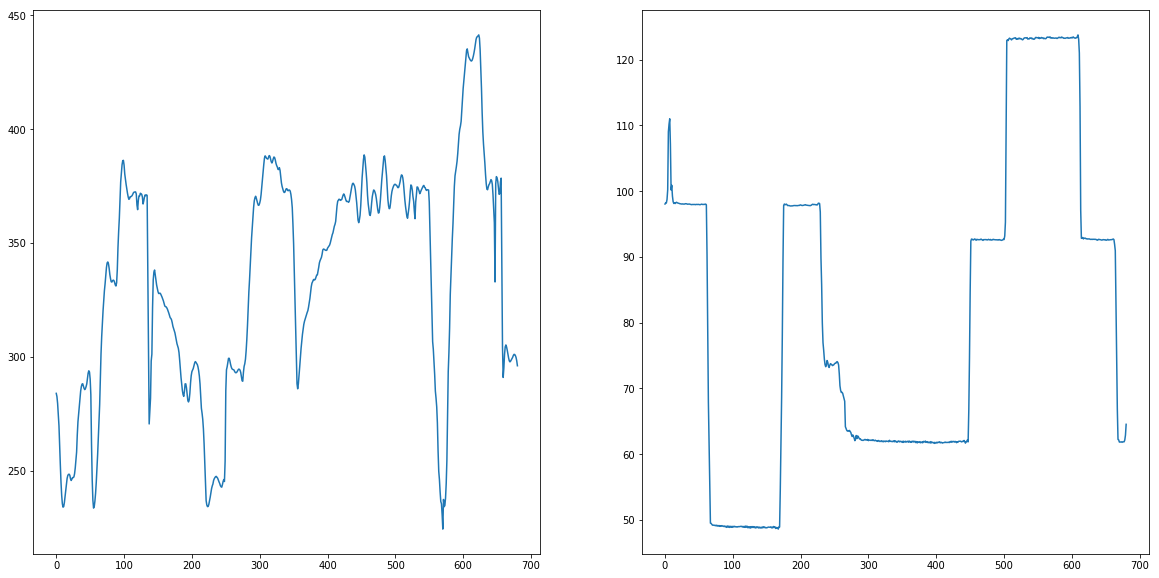

In [6]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(vocals_frequency)
plt.subplot(1,2,2)
plt.plot(bass_frequency)

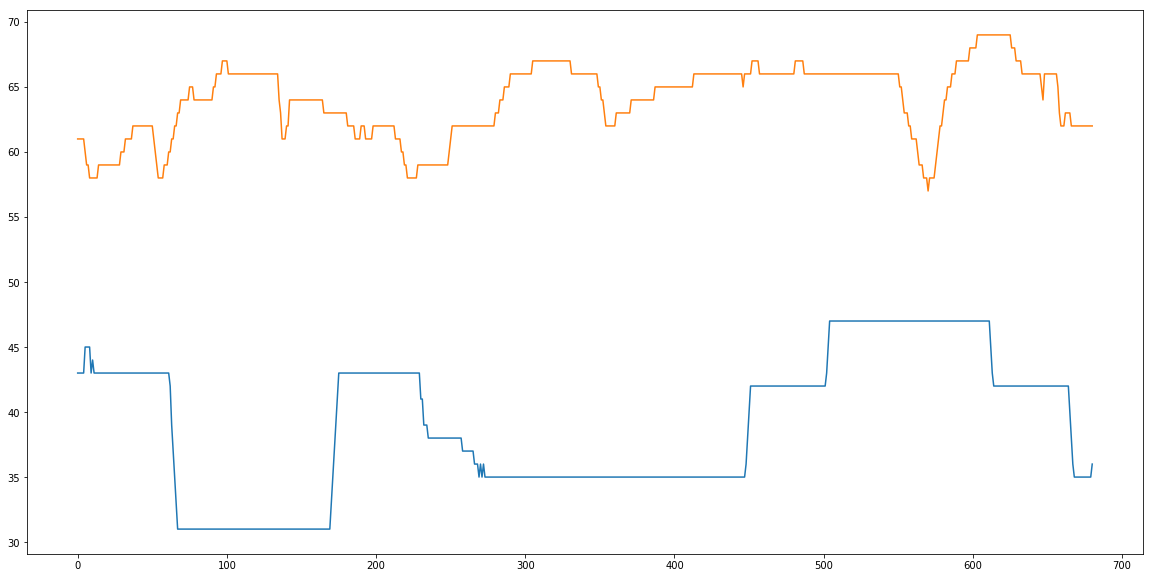

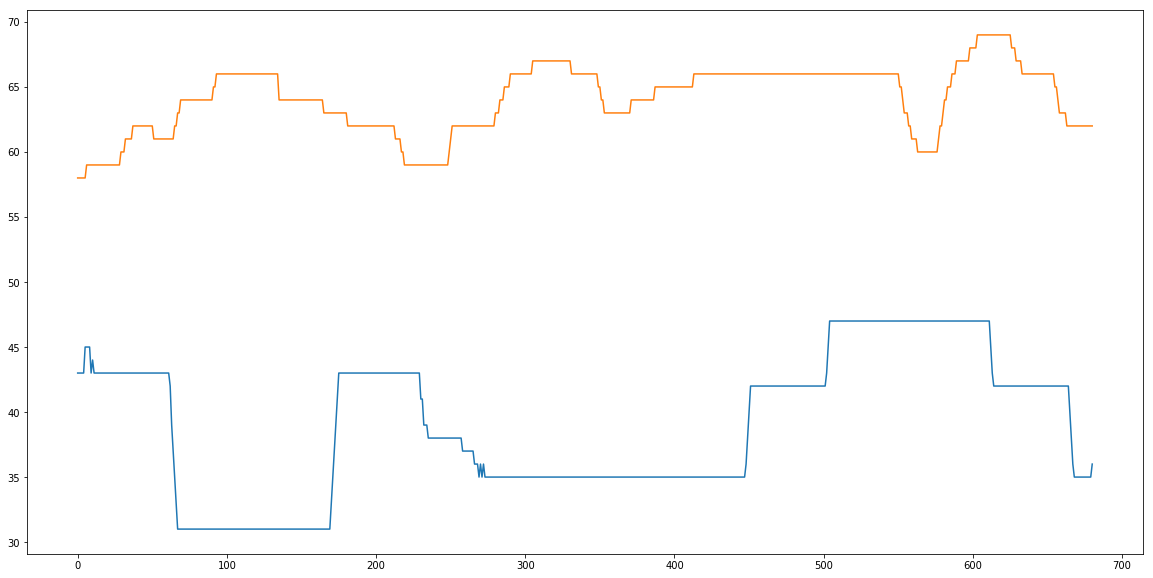

In [7]:
from scipy.signal import medfilt


def hz2midi(hz):
    # convert from Hz to midi note
    hz_nonneg = hz.copy()
    idx = hz_nonneg <= 0
    hz_nonneg[idx] = 1
    midi = 69 + 12*np.log2(hz_nonneg/440.)
    midi[idx] = 0
    # round
    midi = np.round(midi)
    return midi


vocals_midi = hz2midi(vocals_frequency)
bass_midi = hz2midi(bass_frequency)

plt.figure(figsize=(20,10))
plt.plot(bass_midi)
plt.plot(vocals_midi)
plt.show()


vocals_midi = medfilt(vocals_midi, 25)
bass_mid = medfilt(bass_midi, 25)

plt.figure(figsize=(20,10))
plt.plot(bass_midi)
plt.plot(vocals_midi)
plt.show()

In [8]:
def note_segment(midi_contour): 
    
    notes = []
    p_prev = 0
    duration = 0
    onset = 0
    
    for n, p in enumerate(midi_contour):
        if p == p_prev:
            duration += 1
        else:
            # treat 0 as silence
            if p_prev > 0:
                # add note
                duration_sec = duration * 0.1
                # only add notes that are long enough
                if duration_sec >= 2.0:
                    onset_sec = onset * 0.1
                    notes.append((onset_sec, duration_sec, p_prev))
            # start new note
            onset = n
            duration = 1
            p_prev = p

    # add last note
    if p_prev > 0:
        # add note
        duration_sec = duration * 0.1
        onset_sec = onset * 0.1 
        notes.append((onset_sec, duration_sec, p_prev))
    return notes

In [9]:
bass_notes = note_segment(bass_midi)
for note in bass_notes: 
    print(note)
    
vocal_notes = note_segment(vocals_midi)
for note in vocal_notes: 
    print(note)

(1.1, 5.1000000000000005, 43.0)
(6.7, 10.3, 31.0)
(17.5, 5.5, 43.0)
(23.5, 2.3000000000000003, 38.0)
(27.3, 17.5, 35.0)
(45.1, 5.1000000000000005, 42.0)
(50.400000000000006, 10.8, 47.0)
(61.400000000000006, 5.1000000000000005, 42.0)
(68.0, 0.1, 36.0)
(0.6000000000000001, 2.3000000000000003, 59.0)
(6.9, 2.2, 64.0)
(9.3, 4.2, 66.0)
(13.5, 3.0, 64.0)
(18.1, 3.2, 62.0)
(21.900000000000002, 3.0, 59.0)
(25.1, 2.9000000000000004, 62.0)
(30.5, 2.6, 67.0)
(38.7, 2.6, 65.0)
(41.300000000000004, 13.8, 66.0)
(60.300000000000004, 2.3000000000000003, 69.0)
(63.300000000000004, 2.2, 66.0)
(66.3, 1.8, 62.0)


A4
1.1 43.0 G2 5.1000000000000005 1
6.7 31.0 G1 10.3 2
17.5 43.0 G2 5.5 1
23.5 38.0 D2 2.3000000000000003 0
27.3 35.0 B1 17.5 3
45.1 42.0 F#2 5.1000000000000005 1
50.400000000000006 47.0 B2 10.8 2
61.400000000000006 42.0 F#2 5.1000000000000005 1
68.0 36.0 C2 0.1 0


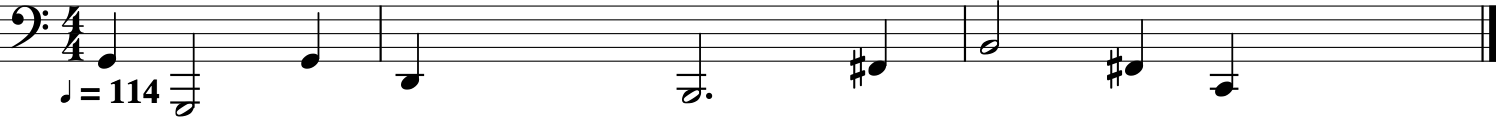

In [11]:
import music21

a = np.array([5.1, 10.3, 5.5, 17.5, 5.1, 0.1, 4.2, 3.0, 3.2, 3.0, 13.8]) / 3.0 
a = a.astype(int)


def midi2name(note_number):
    # Note names within one octave
    semis = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    # Get the semitone and the octave, and concatenate to create the name
    return semis[note_number % 12] + str(note_number//12 - 1)


print(midi2name(69))

bass_stream = music21.stream.Stream()
bass_stream.append(music21.tempo.MetronomeMark(number=114))

for n in bass_notes: 
    print(n[0], n[2],midi2name (int(n[2])), n[1], int(np.round((n[1]) / 5.1)))
    note = music21.note.Note(midi2name(int(n[2])))
    note.quarterLength = int(np.round((n[1]) / 5.1))
    bass_stream.append(note)

bass_stream.show() 
bass_stream.show('midi')


0.6000000000000001 59.0 B3 2.3000000000000003 0
6.9 64.0 E4 2.2 0
9.3 66.0 F#4 4.2 1
13.5 64.0 E4 3.0 1
18.1 62.0 D4 3.2 1
21.900000000000002 59.0 B3 3.0 1
25.1 62.0 D4 2.9000000000000004 1
30.5 67.0 G4 2.6 1
38.7 65.0 F4 2.6 1
41.300000000000004 66.0 F#4 13.8 3
60.300000000000004 69.0 A4 2.3000000000000003 0
63.300000000000004 66.0 F#4 2.2 0
66.3 62.0 D4 1.8 0


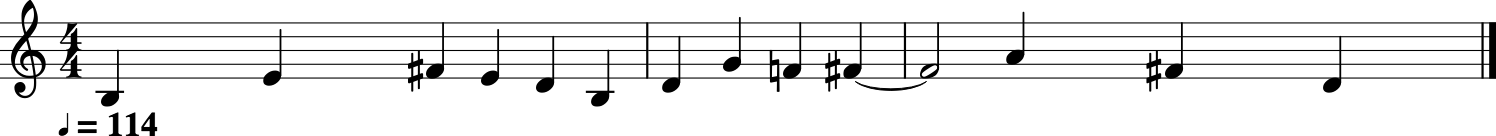

In [12]:
vocal_stream = music21.stream.Stream()
vocal_stream.append(music21.tempo.MetronomeMark(number=114))

for n in vocal_notes: 
    print(n[0], n[2],midi2name (int(n[2])), n[1], int(np.round((n[1]) / 5.1)))
    note = music21.note.Note(midi2name(int(n[2])))
    note.quarterLength = int(np.round((n[1]) / 5.1))
    vocal_stream.append(note)

vocal_stream.show() 
vocal_stream.show('midi')




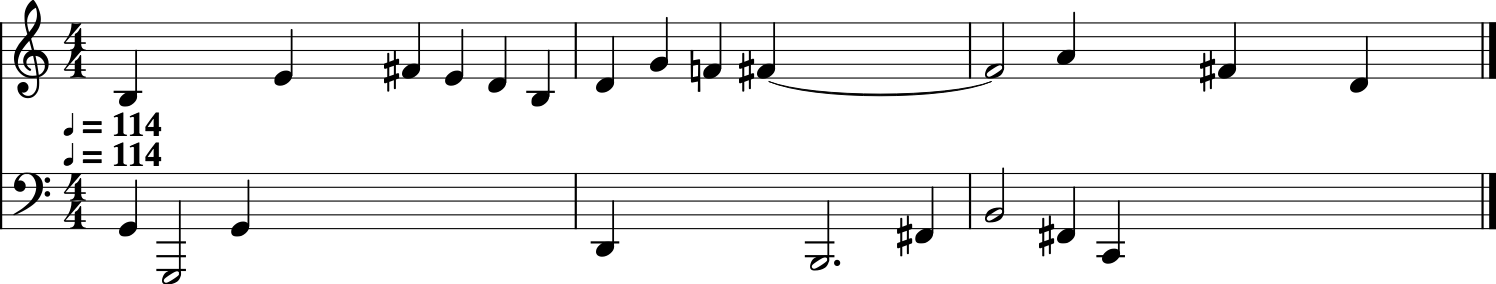

In [13]:
mix_score = music21.stream.Score()
mix_score.insert(0,vocal_stream)
mix_score.insert(0,bass_stream)
mix_score.show()
mix_score.show('midi')

In [15]:
mix.embed_audio()
print(mix)

AudioSignal (unlabeled): 6.803 sec @ Music Delta - Beatles, 44100 Hz, 2 ch.


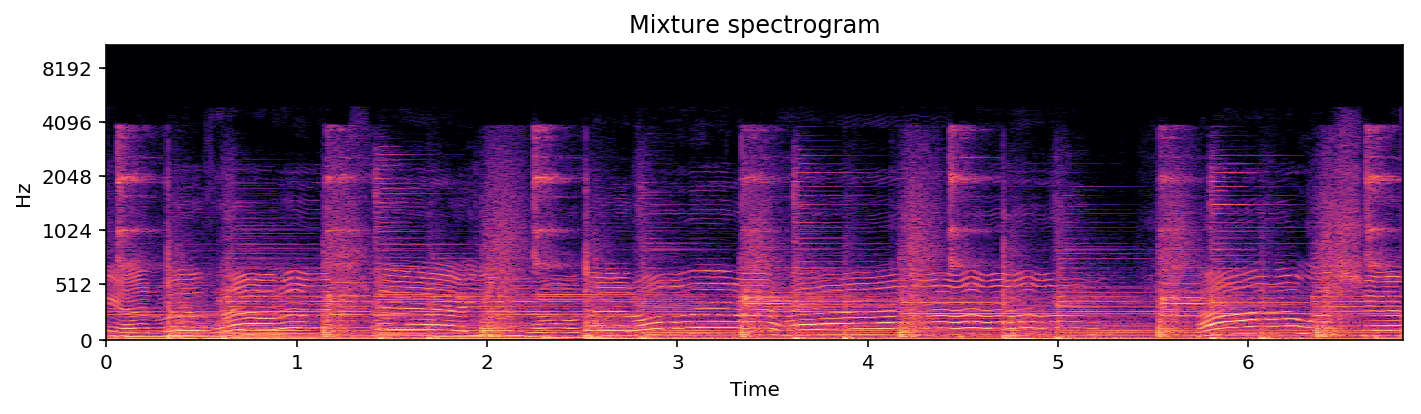

In [16]:
plt.figure(figsize=(10, 3))
plt.title('Mixture spectrogram')
nussl.utils.visualize_spectrogram(mix, y_axis='mel')
plt.tight_layout()
plt.show()

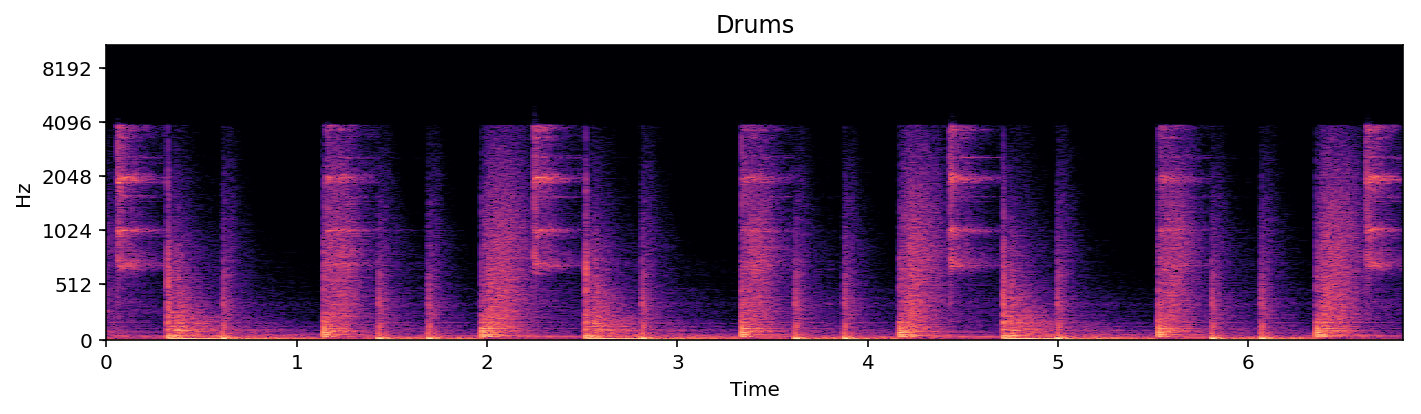

In [17]:
plt.figure(figsize=(10, 3))
plt.title('Drums')
nussl.utils.visualize_spectrogram(sources['drums'], y_axis='mel')
plt.tight_layout()
plt.show()


In [18]:
mask_data = (
    np.abs(sources['drums'].stft()) /
    np.maximum(
        np.abs(mix.stft()),
        np.abs(sources['drums'].stft())
    ) + nussl.constants.EPSILON
)

magnitude, phase = np.abs(mix.stft_data), np.angle(mix.stft_data)
masked_abs = magnitude * mask_data
masked_stft = masked_abs * np.exp(1j * phase)

drum_est = mix.make_copy_with_stft_data(masked_stft)
drum_est.istft()
drum_est.embed_audio()

plt.figure(figsize=(10, 3))
plt.title('Separated drums')
nussl.utils.visualize_spectrogram(drum_est, y_axis='mel')
plt.tight_layout()
plt.show()

To summarize, automatic music transcription refers to the process of estimating a symbolic music representation 
such as MIDI or MusicXML from an audio signal. Sound source separation refers to the process of extracting audio signals corresponding to the individual sound sources that comprise a sound mixture. 

In this notebook, we made a lot of simplifying assumptions to illustrate the concepts. 

For the transcription example, we took advantage that the data provides separate tracks for the different sound sources to perform monophonic pitch transcription for the vocals and the melody. For the note segmentation part we made it sort of work in a hacky way by an educated guess for the duration of quarter notes. For the sound source separation again we took advantage of the availability of the separated tracks in order to perform the separation using time/frequency masking. 

Obsiously, automatic music transcription systems and sound source separation systems are much more complicated and can not make these simplifying assumptions. We will be exploring in more detail both transcription and sound source separation algorithms. 

Finally, these two tasks although different are to some extent related and they can inform each other. For example as we have seen having the separated audio tracks helps with transcription. The availability of a symbolic score can also be used to inform sound source separation algorithms. 

